In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, os
from matplotlib import pyplot as plt
import torch
from itertools import product
from tqdm import tqdm
import pickle

from typing import Callable
from PIL import Image

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
# sys.path.append(os.path.join(os.getcwd(), '../sympde/viz'))

from torchvision.transforms import Compose, RandomRotation, CenterCrop, Pad, ToTensor, Resize, RandomCrop
from torchvision.transforms import RandomAffine, InterpolationMode
from data.transforms import ToArray, Slice, SqueezeTransform, BaseTransform, SpaceTranslate, RandomPad, RandomScale, CustomRandomRotation, UnsqueezeTransform, MyPad, MyPrint

# from general_plots import simple_imshow, imshow, imshows

from data.generate_flat import create_flat, plot_flat

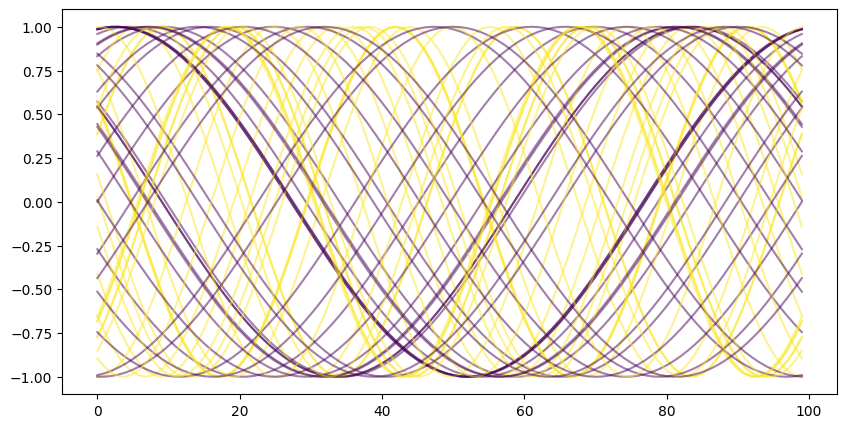

In [16]:
data_kwargs = {
    'space_length': 7,
    'noise_std': 0.5,
    'y_low': 1,
    'y_high': 3,
}

data_kwargs = {
    'space_length': 100,
    'noise_std': 0.,
    'y_low': 1,
    'y_high': 3,
}

outs = create_flat(N = 50, **data_kwargs)
x, y = outs['x'], outs['y']

plot_flat(x, y)

# save_splits(
#     create_sample_func=create_flat,
#     data_kwargs = data_kwargs,
#     data_dir = '../data/flat/',
# )   

## 2D

In [ ]:
data_kwargs = {
    'space_length': 200**2,
    'noise_std': 0.0,
    'y_low': 2,
    'y_high': 5,
}
def create_2d(N: int, space_length: int, noise_std: float, y_low: int, y_high: int):

    sqrt = np.sqrt(space_length)
    space_length = int(sqrt)
    assert space_length == sqrt

    space_length_large = space_length

    x = np.linspace(0, 1, space_length_large)
    xx, yy = np.meshgrid(x, x)
    xx, yy = np.expand_dims(xx, -1), np.expand_dims(yy, -1)

    ks = np.random.randint(y_low, y_high, size = (N))
    angles = np.random.randint(0, 1, size = (N))
    sins = np.sin(2*np.pi*ks*(xx + yy)).T

    transform = Compose([
        MyPad(pad_width = space_length_large//2, mode = 'wrap'),
        ToTensor(),
        RandomRotation(degrees=(-90, 90), fill = 0., interpolation=Image.BILINEAR),
        CenterCrop(space_length),
        # Resize((space_length,space_length)),
    ])
    sins = torch.cat([transform(sin) for sin in tqdm(sins, leave=False)]).numpy()
    # sins = np.sin(2*np.pi*ks*(xx*np.cos(angles) + yy*np.cos(angles))).T

    # angles = np.arccos(0.1)
    # sins = np.sin(2*np.pi*ks*(xx + yy)*2.).T

    sins = sins.reshape(N, space_length**2)
    noise = np.random.normal(0, noise_std, size = (N, space_length**2))
    sins_noised = sins + noise
    return sins_noised, ks
N_plot = 4
x, y = create_2d(N = N_plot, **data_kwargs)

fig, axs = plt.subplots(1, N_plot, figsize = (N_plot*3, 3), sharey=True, sharex=True)
fig2, axs2 = plt.subplots(1, N_plot, figsize = (N_plot*3, 3), sharey=True, sharex=True)
for i in range(N_plot):
    x_i = x[i]
    space_length = int(np.sqrt(data_kwargs['space_length']))
    x_i = x_i.reshape(space_length, space_length)
    axs[i].imshow(x_i, aspect='auto')
    axs[i].set_title(f'y = {y[i]}')

    for j in range(3):
        k = np.random.randint(0, space_length)
        # axs2[i].plot(x_i[k], color = 'tab:blue')
        axs2[i].plot(x_i[:, k], color = 'tab:orange')
        assert all(x_i[:, k] == x_i.T[k])
plt.show()

# save_splits(
#     create_sample_func=create_2d,
#     data_kwargs = data_kwargs,
#     data_dir = '../data/2d/',
# )   

In [ ]:
x_i.shape

In [ ]:
for x_ii in x_i[:10]:
    x_ii_trunc = truncate_to_integer_cycles(x_ii)

    fig, axs = plt.subplots(1, 1, figsize = (6, 3))
    ax = axs
    print(x_ii_trunc.shape, x_ii.shape)
    ax.plot(x_ii_trunc, color = 'tab:blue')
    ax.plot(x_ii, color = 'tab:orange')
    plt.show()

In [ ]:
import numpy as np
from scipy.signal import find_peaks

def estimate_wavelength(data):
    """
    Estimate the wavelength of a sine wave from its peaks.

    :param data: NumPy array containing the sine wave.
    :return: Estimated wavelength as an integer.
    """
    peaks, _ = find_peaks(data)
    if len(peaks) > 1:
        # Calculate average distance between peaks
        wavelengths = np.diff(peaks)
        avg_wavelength = int(np.round(np.mean(wavelengths)))
    else:
        avg_wavelength = len(data)  # Default to the length of the data if only one peak is found
    return avg_wavelength

def truncate_to_integer_cycles(data):
    """
    Truncate a sine wave array to contain only an integer number of cycles.

    :param data: NumPy array containing the sine wave.
    :return: Truncated NumPy array.
    """
    wavelength = estimate_wavelength(data)
    num_cycles = len(data) // wavelength
    return data[:num_cycles * wavelength]

# Example usage
data = np.sin(np.linspace(0, 2.6 *2*np.pi, 100))  # Example sine wave
truncated_data = truncate_to_integer_cycles(data)
truncated_data.size, data.size  # Display the sizes of the truncated and original data for comparison


In [ ]:
plt.plot(data)
plt.plot(truncated_data)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the sine wave
amplitude = 1.0
frequency = 2.3  # Adjust the frequency as needed
duration = 2.0  # Adjust the duration as needed
sampling_rate = 1000  # Adjust the sampling rate as needed

# Generate the sine wave
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)

# Calculate the number of cycles
num_cycles = duration * frequency

# Cut away the last values to have an integer number of cycles
cut_index = int(num_cycles * sampling_rate)
sine_wave_cut = sine_wave[:cut_index]

# Plot the original and cut sine waves
plt.plot(t, sine_wave, label='Original Sine Wave')
plt.plot(t[:cut_index], sine_wave_cut, label='Cut Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
space_length = 100

kx, ky = np.random.randint(1, 4, size = (2))
kx, ky = 2, -3
x = np.linspace(0, 2*pi*kx, space_length)
y = np.linspace(0, 2*pi*ky, space_length)

xx, yy = np.meshgrid(x, y)
fig, axs = plt.subplots(1, 10, figsize = (10*3, 3))
for w in range(10):
    sin = np.sin(xx + yy - w)
    axs[w].imshow(sin)
plt.show()



In [ ]:
x.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
num_points = 100
theta = np.linspace(0, 2*np.pi, num_points)

# Flower petal shape using sine functions
radius = 1
petal_width = 10.

x = radius * np.sin(2 * theta) * np.cos(theta)
y = radius * np.sin(2 * theta) * np.sin(theta)

# Plot the flower shape
plt.plot(x, y, label='Flower Shape')
plt.title('Flower Shape Using Sine Functions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.axis('equal')  # Equal scaling for a better view
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
num_points = 500
theta = np.linspace(0, 2*np.pi, num_points)

# Flower petal shape using sine functions
radius = 0.1
petal_width = 1.

x = radius * np.sin(2 * theta) * np.cos(theta)
y = radius * np.sin(2 * theta) * np.sin(theta)

# Create a grid
x_grid = np.linspace(-1.5, 1.5, 500)
y_grid = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x_grid, y_grid)

# Create an empty image
flower_image = np.zeros_like(X)

# Check if the points are inside the flower shape
for i in range(num_points):
    distance = np.sqrt((X - x[i])**2 + (Y - y[i])**2)
    flower_image += np.exp(-distance**2 / (2 * petal_width**2))

# Plot the flower shape using plt.imshow
plt.imshow(flower_image, extent=(-1.5, 1.5, -1.5, 1.5), cmap='viridis')
plt.title('Flower Shape Using Sine Functions (plt.imshow)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Intensity')
plt.show()


In [ ]:
l = 0.6
k = 4.
x = np.linspace(0, 1, 100)
sin = np.sin(2*pi*k*x)

plt.plot(x, sin)
# plt.plot(sin)
plt.show()

In [ ]:
x_plots = x.reshape(N_plot, space_length, space_length)[:4, 7]
y_plots = x.reshape(N_plot, space_length, space_length)[:4, :, 7]

for x_plot in x_plots:
    plt.plot(x_plot, alpha = 0.5)
plt.show()

for y_plot in y_plots:
    plt.plot(y_plot, alpha = 0.5)
plt.show()

In [ ]:
plt.plot(x_i[0])
plt.plot(x_i[:, 0])

In [ ]:
plt.imshow(x_i, aspect='auto')
plt.show()

plt.imshow(x_i_padded, aspect='auto')
plt.show()

# Old stuff

In [ ]:
# arange = np.arange(y_low, y_high+1)
# kxs, kys = torch.tensor(list(product(arange, arange))).T

# fig, axs = plt.subplots(len(arange), len(arange), figsize = (len(arange)*3, len(arange)*3), sharey=True, sharex=True)
# axs = axs.flatten()
# for i, (kx, ky) in enumerate(zip(kxs, kys)):
#     sin = np.sin(2*np.pi*kx*xx + 2*np.pi*ky*yy).T.squeeze()
#     axs[i].imshow(sin, aspect='auto')
#     axs[i].set_title(f'kx={kx}, ky={ky}')

In [ ]:
# from torch.utils.data import Dataset
# from torchvision.transforms import RandomRotation
# from torchvision.transforms import Pad
# from torchvision.transforms import Resize
# from torchvision.transforms import ToTensor
# from torchvision.transforms import Compose
# from tqdm.auto import tqdm
# from PIL import Image

# resize1 = Resize(87) # to upsample
# resize2 = Resize(29) # to downsample

# totensor = ToTensor()

In [ ]:

# # Open the image file
# img = image_data = np.random.randn(28, 28) + 10
# original_image = Image.fromarray(img, mode='F')

# # Rotate the image by a specified angle (in degrees)
# angle_to_rotate = 10  # You can change this value to the desired rotation angle
# rotated_image = original_image.rotate(angle_to_rotate)
# img2 = np.array(rotated_image)

# fig, axs = plt.subplots(1, 2, figsize = (6, 3))
# axs[0].imshow(img, cmap='gray')#, interpolation='nearest')
# axs[1].imshow(img2, cmap='gray', vmin=-10, vmax=10)#, interpolation='nearest')
# plt.show()

In [ ]:
import math

def rotatedRectWithMaxArea(w, angle):
  """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.

  Adapted from: https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
  """
  h = w
  if w <= 0 or h <= 0:
    return 0,0

  width_is_longer = w >= h
  side_long, side_short = (w,h) if width_is_longer else (h,w)

  # since the solutions for angle, -angle and 180-angle are all the same,
  # if suffices to look at the first quadrant and the absolute values of sin,cos:
  sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
  if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
    # half constrained case: two crop corners touch the longer side,
    #   the other two corners are on the mid-line parallel to the longer line
    x = 0.5*side_short
    wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
  else:
    # fully constrained case: crop touches all 4 sides
    cos_2a = cos_a*cos_a - sin_a*sin_a
    wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

  assert np.allclose(wr, hr), f'{wr} != {hr}'

  return wr

angles = np.arange(0, 90)
wrs = np.array([rotatedRectWithMaxArea(128, math.radians(angle)) for angle in angles])
assert angles[np.argmin(wrs)] == 45
# s_min = int(rotatedRectWithMaxArea(space_length, math.radians(45)))

In [ ]:

transform = Compose([
    MyPad(pad_width = space_length//2),
    ToTensor(),
    RandomRotation(degrees=180, fill = 0., interpolation=Image.BILINEAR),
    CenterCrop(space_length),
])


sins_rotated = torch.cat([transform(sin) for sin in tqdm(x, leave=False)])
sins_org = torch.from_numpy(x)

# print( torch.allclose(sins_org, sins_rotated) )

N_plots = 2
fig, axs = plt.subplots(N_plots, 2, figsize = (6, 3*N_plots))
for i in range(N_plots):
    axs[i, 0].imshow(sins_org[i], cmap='gray')
    axs[i, 1].imshow(sins_rotated[i], cmap='gray')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the grid
num_points = 100
theta = np.linspace(0, 2*np.pi, num_points)
radius = 1.0  # radius of the circle

# Create a meshgrid in polar coordinates
theta_grid, radius_grid = np.meshgrid(theta, radius)

# Map the sine function onto the polar coordinates
sine_pattern = np.sin(theta_grid)

# Convert polar coordinates to Cartesian coordinates
x = radius_grid * np.cos(theta_grid)
y = radius_grid * np.sin(theta_grid)

# Plot the result
plt.figure(figsize=(8, 8))
plt.pcolormesh(x, y, sine_pattern, cmap='viridis')
plt.colorbar(label='Sine Value')
plt.title('2D Sine Pattern with Circular Boundary Conditions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('auto')  # Ensure that the aspect ratio is equal for a circle
plt.show()


In [ ]:
sine_pattern.shape

# Flower

In [5]:
from data.generate_flower import create_flower, plot_flower
from data.transforms import Transform

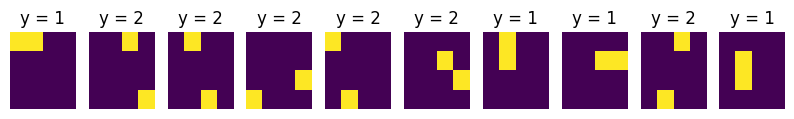

In [12]:
out = create_flower(N=10, space_length=4**2, noise_std=0., y_low=1, y_high=3)
x, y, centers = out['x'], out['y'], out['centers']
x = x.reshape(10, 4, 4)
plot_flower(x=x, y=y)

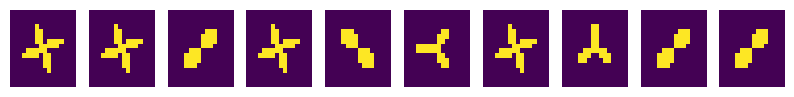

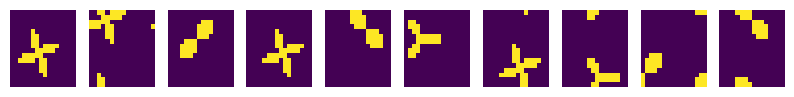

In [38]:
transform_rotate = Transform(epsilons=[0., 1., 0., 0.])
transform        = Transform()

x1, center1 = transform_rotate(x, centers, transform_individual_bool=True)
plot_flower(x1)

x_new, center_new = transform(x1, center1, transform_individual_bool=True)
plot_flower(x_new)

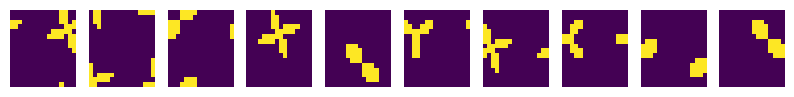

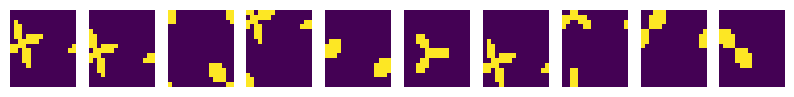

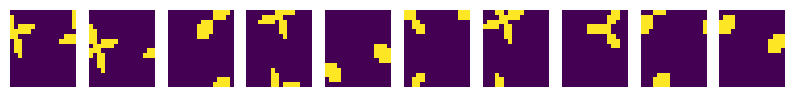

In [36]:
x_new, centers_new = x, centers
for _ in range(3):
    x_new, centers_new = transform(x_new, centers_new, transform_individual_bool = True)
    plot_flower(x_new)

In [51]:
# for x_i in x[:10].reshape(10, 16, 16):
#     plt.imshow(x_i)
#     plt.show()

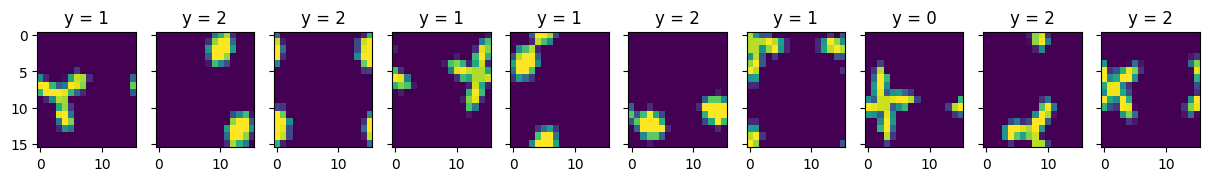

In [406]:




N_plot = 10
x = np.load(os.path.join('../data/flower/train', 'x_space_length=256_noise_std=0.0_y_low=2_y_high=5.npy'))
with open(os.path.join('../data/flower/train', 'augment_kwargs_space_length=256_noise_std=0.0_y_low=2_y_high=5.pkl'), 'rb') as f:
    augment_kwargs = pickle.load(f)
# out = create_flower(N = N_plot, **data_kwargs)
# x, y, augment_kwargs = out['x'], out['y'], out['augment_kwargs']
l = 16
x = torch.from_numpy(x[:N_plot].reshape(N_plot, l, l))

plot_flower(x, y = y, l = 1.5)

# x0 = torch.from_numpy(x)
# augment_kwargs0 = augment_kwargs


# save_splits(
#     create_sample_func=create_flower,
#     data_kwargs = data_kwargs,
#     data_dir = '../data/flower/',
# )  


In [407]:
from data.generate_flower import transform

In [408]:
augment_kwargs

[{'SpaceTranslate_1': 0.10681337118148804,
  'SpaceTranslate_2': 0.7707936763763428},
 {'SpaceTranslate_1': 0.5065659284591675,
  'SpaceTranslate_2': 0.2827519178390503},
 {'SpaceTranslate_1': 0.5354644060134888,
  'SpaceTranslate_2': 0.5267181396484375},
 {'SpaceTranslate_1': 0.8876929879188538,
  'SpaceTranslate_2': 0.4090538024902344},
 {'SpaceTranslate_1': 0.6340725421905518,
  'SpaceTranslate_2': 0.766785740852356},
 {'SpaceTranslate_1': 0.2924812436103821,
  'SpaceTranslate_2': 0.6067171096801758},
 {'SpaceTranslate_1': 0.6598854064941406,
  'SpaceTranslate_2': 0.6235878467559814},
 {'SpaceTranslate_1': 0.1354348063468933,
  'SpaceTranslate_2': 0.6955598592758179},
 {'SpaceTranslate_1': 0.40526455640792847,
  'SpaceTranslate_2': 0.011449158191680908},
 {'SpaceTranslate_1': 0.04460102319717407,
  'SpaceTranslate_2': 0.6616808176040649},
 {'SpaceTranslate_1': 0.16533029079437256,
  'SpaceTranslate_2': 0.34687668085098267},
 {'SpaceTranslate_1': 0.3209068775177002,
  'SpaceTranslate

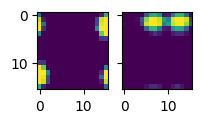

In [149]:
i = 2
x1 = x[i].unsqueeze(0)
x2, _ = transform(
    x = x1,
    augment_kwargs = augment_kwargs[i],
    # augment_kwargs = {'SpaceTranslate_1' : 0.0, 'SpaceTranslate_2': 0.0},
    sample = True
)

plot_flower(torch.cat([x1, x2]))

In [86]:
x_org = x.clone()

In [83]:
shifts

tensor([0, 1, 0, 1, 3])

x


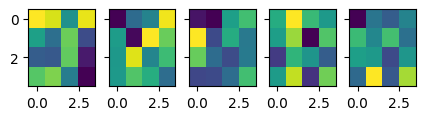

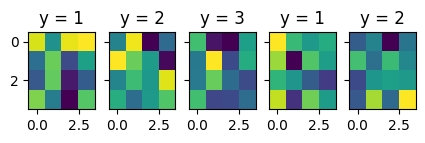

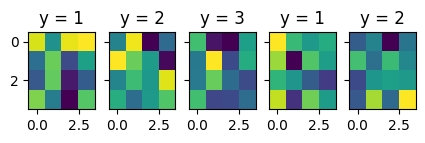

y


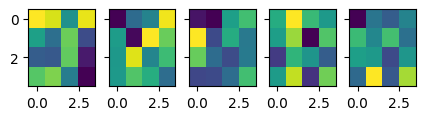

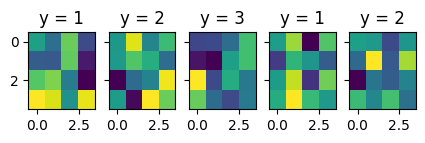

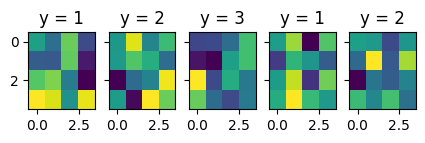

In [85]:
def batch_space_translate(x: torch.Tensor, shifts: torch.Tensor, shift_dir: str) -> torch.Tensor:
    """Translate a batch of images by a specified number of pixels.

    Args:
        x: Batch of images of shape (batch_size, height, width).
        shifts: Batch of shifts of shape (batch_size, 2).

    Returns:
        Batch of translated images of shape (batch_size, height, width).
    """
    batch_size, height, width = x.shape
    assert height == width

    # Create an index tensor
    indices = torch.arange(height).unsqueeze(0).expand(len(shifts), -1)

    # Use broadcasting to create tensor b
    b = indices < shifts.unsqueeze(1)
    i1, i2 = torch.tensor(1), torch.tensor(0)
    b21 = torch.where(b, i1, i2).unsqueeze(2)
    b22 = torch.where(b, i2, i1).unsqueeze(2)
    # b2 = torch.where(b, torch.tensor(1), torch.tensor(0)).unsqueeze(2)
    

    if shift_dir == 'x': x = torch.transpose(x, 1, 2)
    x = torch.cat([x * b22, x * b21], dim = 1)
    indices2 = torch.where(x != 0)
    x = x[[*indices2]].view(batch_size, height, width)
    if shift_dir == 'x': x = torch.transpose(x, 1, 2)

    return x

def batch_space_translate_slow(x: torch.Tensor, shifts: torch.Tensor, shift_dir: str) -> torch.Tensor:
    dim_int = 1 if shift_dir == 'x' else 0
    x = torch.stack([torch.roll(x_i, -shifts[i].item(), dims = dim_int) for i, x_i in enumerate(x)])
    return x

n = 5
l = 4

x = torch.randn(n, l, l)  # 10 tensors of size 3x3
shifts = torch.randint(l, size = (n,))

for shift_dir in ['x', 'y']:
    print(shift_dir)
    x_rolled = batch_space_translate(x, shifts, shift_dir = shift_dir)
    x_rolled_slow = batch_space_translate_slow(x, shifts, shift_dir = shift_dir)

    assert torch.allclose(x_rolled, x_rolled_slow)

    plot_flower(x)
    plot_flower(x_rolled,  y = shifts)
    plot_flower(x_rolled_slow,  y = shifts)

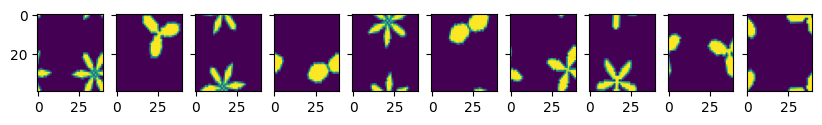

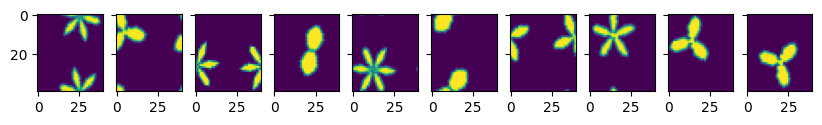

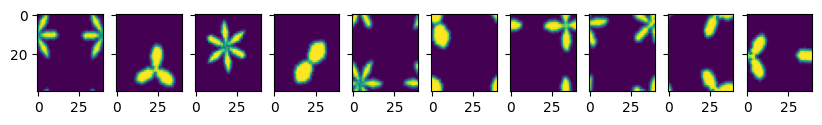

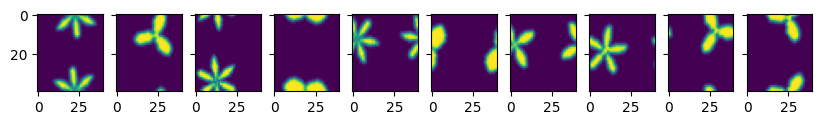

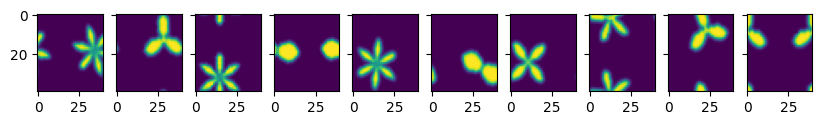

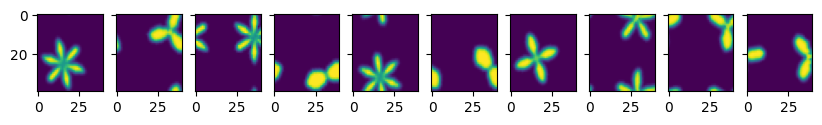

In [7]:
x, augment_kwargs = x0, augment_kwargs0
plot_flower(x)

for _ in range(5):
    x, augment_kwargs = transform_batch(x, augment_kwargs, epsilons = [1., 1., 1., 1.], sample = True)
    plot_flower(x)
